# Assignment 3- Scatterplot, dimension reduction and clustering

You are strongly encouraged to work on this assignment with one or two partners. Please ensure only one submission per group: upload the PDF report to Gradescope and the code (or Jupyter notebook) to D2L. The dataset CSV file for Assignment 3 can be found on D2L.

This dataset is based on real-world data, not synthetic, so don't anticipate very clear-cut clusters or trends. There's no single correct answer to any question. Aim to thoroughly explain your analysis and the reasoning behind your choices as effectively as possible.

In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans



In this assignement, we focus on ```heart failure clinical records dataset```,from [UCI Machine Learning repository](https://archive-beta.ics.uci.edu/). It includes the medical records of 299 patients who had heart failure, collected during their follow-up period, where each patient profile has 13 clinical features  and you can access more information about this dataset [here](https://archive.ics.uci.edu/dataset/519/heart+failure+clinical+records)


In [3]:
heart=pd.read_csv('heart_failure_clinical_records_dataset.csv')

# excludes binary vars
numerical = heart.drop(columns=['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking', 'DEATH_EVENT'])
# excludes numerical vars
categorical = heart.drop(columns=['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time'])

# Problem 1- Scatterplots (50 points) 

### (a) 10 points- (EP)
Get to know the dataset by generating summary statistics for the numerical variables, such as mean, median, and standard deviation. Address any missing values and outliers. Which variables do you think might be crucial in determining patient survival? Which variables seem to be most closely correlated.

[Summary Statistics Pandas Resource](https://pandas.pydata.org/docs/getting_started/intro_tutorials/06_calculate_statistics.html)

- Missing values: No
- Outliers: 
- Crucial Survival Variables: 
- Variables most correlated: 

### (b) 20 points (BH)
Create pair plot and correlation matrix among the different numerical variables. Comment on your findings.

__Pair Plot Findings:__
 - sfsd
 - dfsdfd

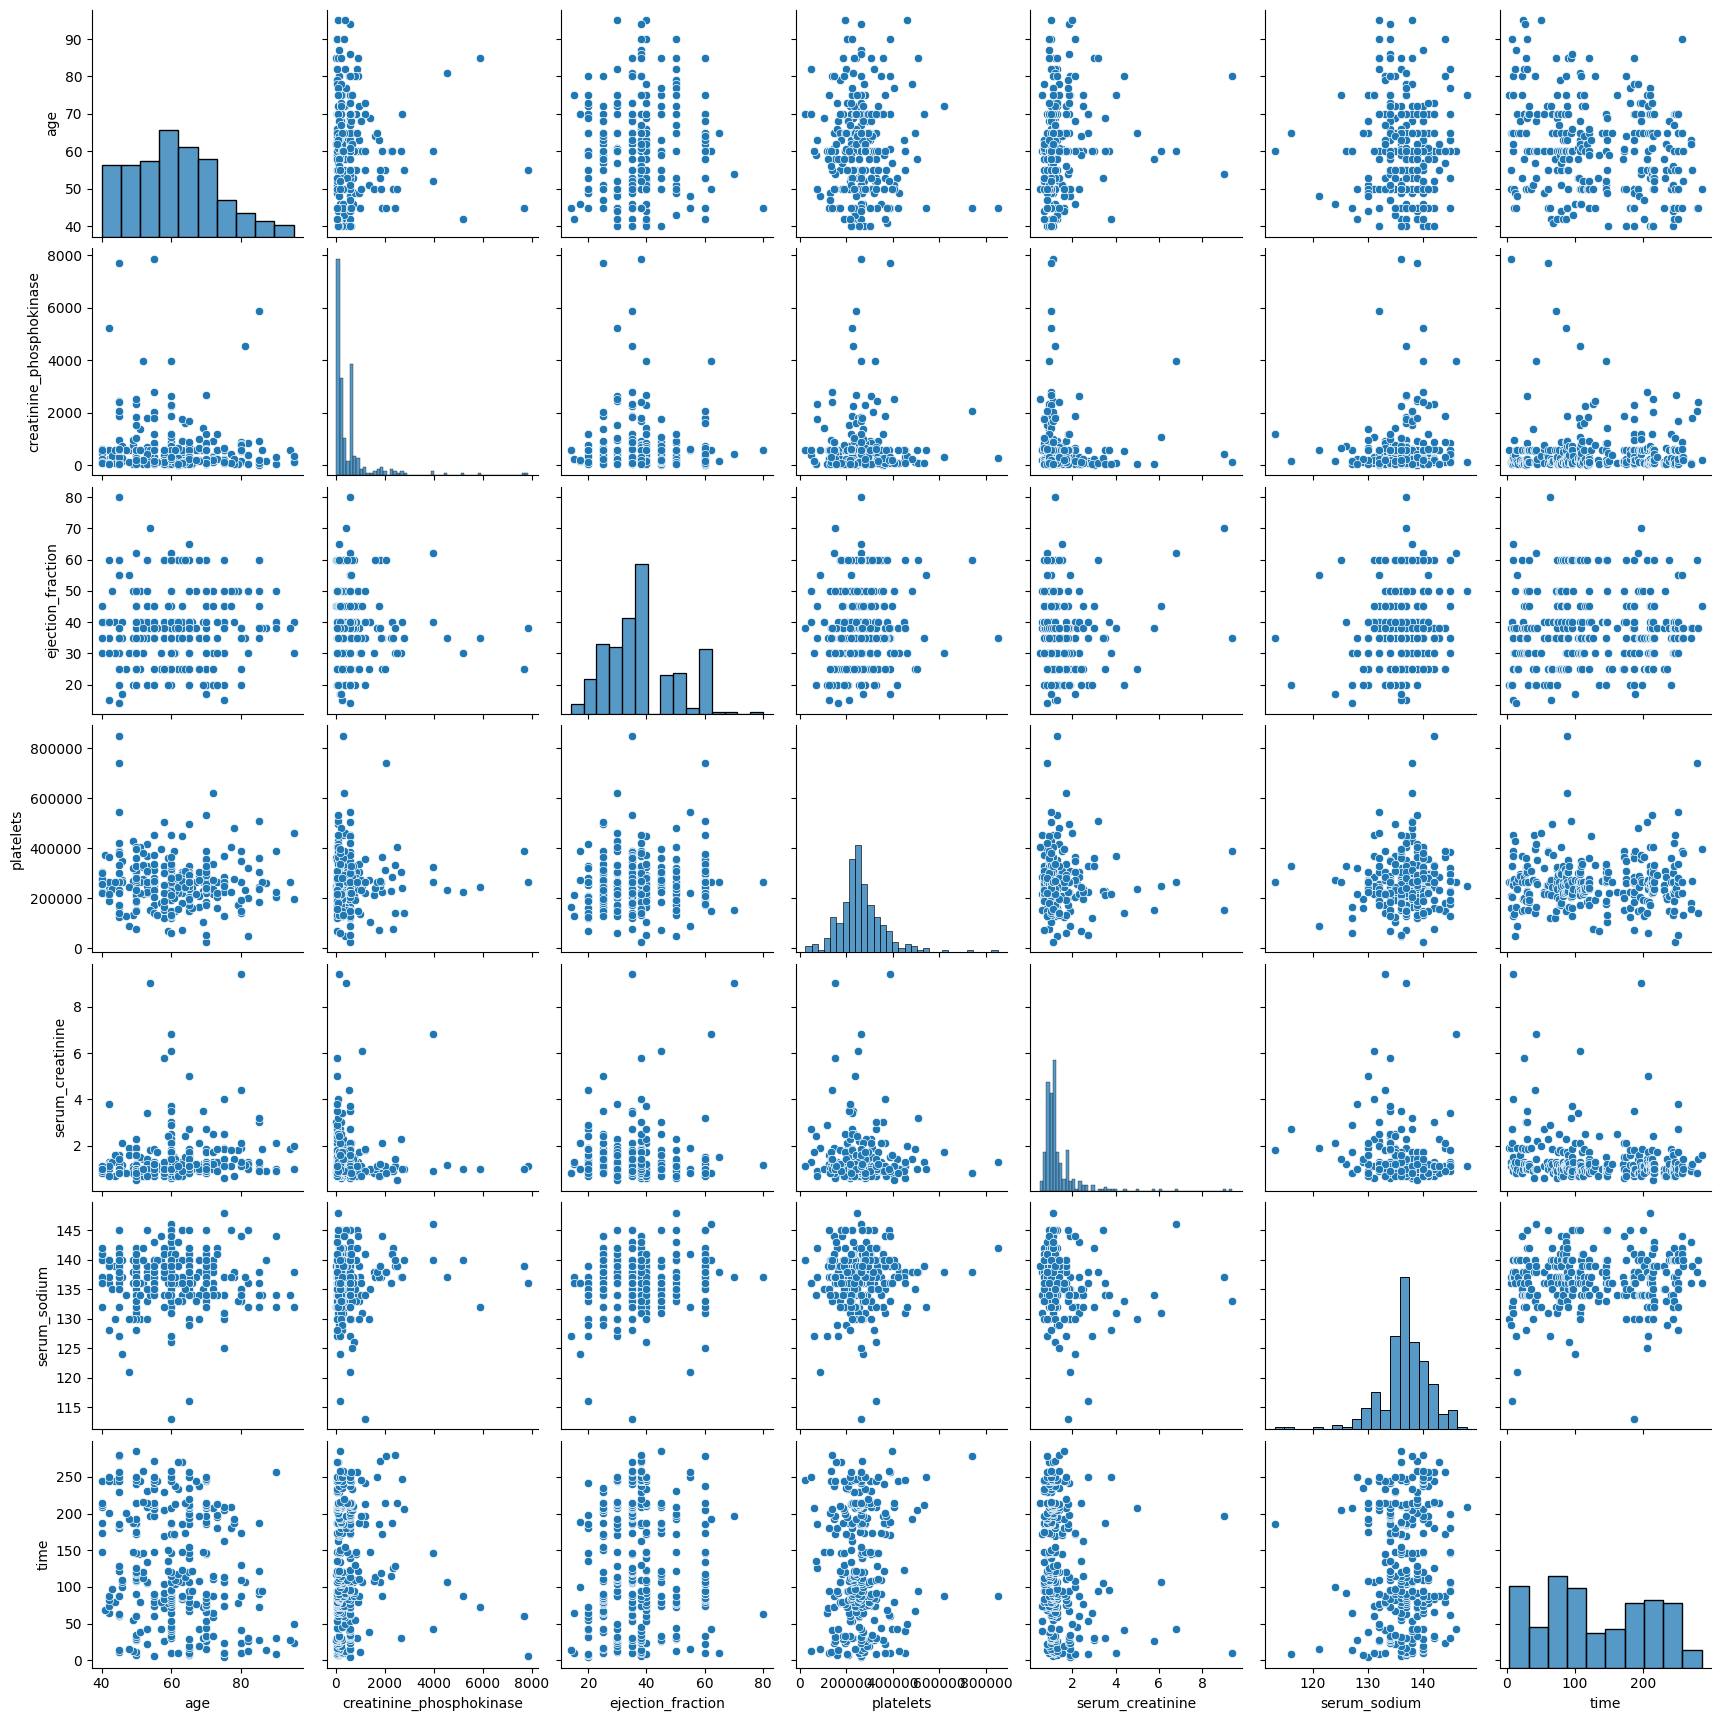

In [4]:
#pair plot
sns.pairplot(numerical)

__Correlation Matrix Findings:__
- sdfds
- sdfds

In [5]:
# Correlation Matrix
correlationMatrix = numerical.corr()
correlationMatrix

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time
age,1.000000,-0.081584,0.060098,-0.052354,0.159187,-0.045966,-0.224068
creatinine_phosphokinase,-0.081584,1.000000,-0.044080,0.024463,-0.016408,0.059550,-0.009346
ejection_fraction,0.060098,-0.044080,1.000000,0.072177,-0.011302,0.175902,0.041729
platelets,-0.052354,0.024463,0.072177,1.000000,-0.041198,0.062125,0.010514
serum_creatinine,0.159187,-0.016408,-0.011302,-0.041198,1.000000,-0.189095,-0.149315
serum_sodium,-0.045966,0.059550,0.175902,0.062125,-0.189095,1.000000,0.087640
time,-0.224068,-0.009346,0.041729,0.010514,-0.149315,0.087640,1.000000


### (c) 20 points (EP)
Explore different pairs of variables. Create two separate scatterplots and color points based on Death variable, `DEATH_EVENT` or other categorical variables. Do you see any ditinctive groups.

# Problem 2- Dimension Reduction (50 points) 

### (a) 15 points (BH)
Perform PCA on the **standardized numerical variables**. Plot cumulative explained variance. 
How many principal components are needed to capture 80% of the variance? Comment on your results.

PCA1: 
age: 0.465 | creatine_phosphokinase: -0.138 | ejection_fraction: -0.1789 | platelets: -0.1993 | serum_creatinine: 0.5118 | serum_sodium: -0.4474 | time: -0.4806 | 
PCA2: 
age: 0.4521 | creatine_phosphokinase: -0.1939 | ejection_fraction: 0.6815 | platelets: 0.2468 | serum_creatinine: 0.0457 | serum_sodium: 0.4297 | time: -0.2143 | 
PCA3: 
age: -0.0078 | creatine_phosphokinase: 0.8151 | ejection_fraction: -0.1067 | platelets: 0.4033 | serum_creatinine: 0.1017 | serum_sodium: 0.118 | time: -0.3706 | 
PCA4: 
age: -0.1981 | creatine_phosphokinase: -0.3344 | ejection_fraction: -0.013 | platelets: 0.821 | serum_creatinine: 0.1823 | serum_sodium: -0.3626 | time: 0.1005 | 
PCA5: 
age: -0.1912 | creatine_phosphokinase: 0.2948 | ejection_fraction: 0.4695 | platelets: -0.1808 | serum_creatinine: 0.6336 | serum_sodium: -0.1514 | time: 0.4462 | 
PCA6: 
age: -0.6341 | creatine_phosphokinase: -0.1009 | ejection_fraction: 0.3913 | platelets: -0.1733 | serum_creatinine: -0.1069 | serum_sodium: -

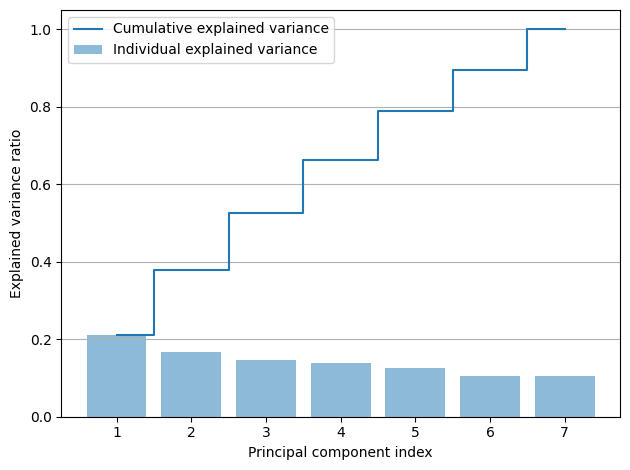

In [6]:
columnTitles = ['age', 'creatine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']

#Standardize numerical set
numericalRescale = StandardScaler().fit_transform(numerical)
numericalRescale = pd.DataFrame(numericalRescale)
numericalRescale.columns = columnTitles


#PCA on standardized Numerial Set (uses 7 components to see which ones are most useful)
numericalPCA = PCA(n_components=7).fit(numericalRescale) #gives me access to .components_ and explained_variance_ratio_


#Prints PCA data
for num, pca in enumerate(numericalPCA.components_, 1):
    s = ''
    for index, title in enumerate(columnTitles):
        s += f"{title}: { str(round(pca[index], 4))} | "
    print(f"PCA{num}: \n{s}")


#cumulative explained variance
ratioSum = numericalPCA.explained_variance_ratio_.cumsum()
print('\ncumulative sum:')
print(ratioSum)

plt.bar(range(1,len(ratioSum)+1), numericalPCA.explained_variance_ratio_, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1,len(ratioSum)+1), ratioSum, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.ylim (0,1.05)
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

In order to get at 80% data capture, we would need at least six principle components. Five was slightly short by sitting at at value of 79.05% coverage.

### (b) 20 points (EP)
Construct a biplot that displays the data points and the loadings of each original feature in the PC1-PC2 space. Label the loading vectors (arrows). Share your observations. Discuss which type of patient is best represented in each quadrant of the plot.

### (c) 15 points (BH)
Color-code the data points based on DEATH_EVENT or other categorical variables within the dataset. Evaluate whether dimension reduction has facilitated a clearer distinction between the various patient groups.

# Problem 3- Clustering (100 points) 

### (a) 15 points (BH)
Apply K-means clustering to the PCA-transformed data (referencing the number of PCA components selected in 2a). Experiment with a variety of K values and graph the resulting Inertias and Average Silhouette Coefficients for each K. Analyze the graphs to determine the optimal number of clusters. Which cluster count do you prefer when considering both metrics?

In [14]:
kmeans = KMeans(n_clusters = 7)
kmeans.fit(numericalPCA.components_[0])

ValueError: Expected 2D array, got 1D array instead:
array=[ 0.46496174 -0.13795934 -0.17889238 -0.19925761  0.51177697 -0.44741078
 -0.48060342].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

### (b) 20 points (BH)
Interpret the characteristics of typical patients in each cluster for the chosen K value from the previous question. This involves reversing the PCA and standard scaler transformations applied to the centroid vectors. Share your insights on the findings. Are there any notable differences between the clusters?

### (c) 20 points (BH)
Using only the first two principal components (PCs), generate two scatterplot subplots. In the first subplot, color-code the data points according to the predicted cluster assignments. In the second subplot, use color-coding to represent 'death' or other categorical variables. Examine both plots and share any significant findings or patterns that become apparent from this comparative analysis.

### (d) 15 points (EP)

Construct dendrograms for various linkage methods (complete, single, ward). Assess which linkage method appears most suitable. Determine the most appropriate number of clusters based on the dendrograms.

### (e) 15 points (EP)
Redo part a of problem 3, but use hierarchical clustering (AgglomerativeClustering) in place of k-means. Use the the linkage type you chose in previous question. Test different numbers of clusters and plot the resulting Inertias and Average Silhouette Coefficients for each cluster count. Examine these plots to identify the ideal number of clusters. Based on both metrics, which number of clusters seems most appropriate? Compare the results with those obtained from part a; did the choice of clustering method lead to a different outcome? 

### (f) 15 points (EP)
Redo part c and compare the results. Any significant difference?